# Bayes4MADMAX

### Bayesian Analysis

This notebook shows you how to handle the Bayesian Analysis with BAT.jl. It assumes background reduced data, so look at the `BGfit_demo` notebook first!

As usual first load the `Bayes4MADMAX` package, but now we also need the BAT package explicitly:

In [1]:
using Revise

In [2]:
using BAT

push!(LOAD_PATH, normpath(@__DIR__, "..", "src"))
using Bayes4MADMAX

Again read data as in `BGfit_demo` notebook, but now you can also read background fit parameters.

Initialize the likelihood function and prior as needed by BAT and initialize the PosteriorDensity therefrom.

In [3]:
dataset = "simulated/tests"
fname = "test"
folder = "Bg_fits_sg"

data = read_data(fname, dataset, "processed_data/"*folder)
ex = read_struct(Experiment, fname, dataset)
signal = read_struct(Theory, fname, dataset)
bg = read_bgfit(fname, dataset, "processed_data/"*folder)

likelihood = make_like(data, fit_function, ex, bg)
prior = make_prior(data, ex; pow=:loggaγγ)

posterior = PosteriorDensity(likelihood, prior)

Reading from /home/th347/diehl/Documents/2103-Bayes/data/simulated/tests/processed_data/Bg_fits_sg


PosteriorDensity(objectid = 0x13a4dec29fd163e6, varshape = NamedTupleShape((:ma, :sig_v, :log_gag)}(…))

Do the actual Bayesian analysis. `sampling` collects all necessary arguments, three viable options are given below. This should take a couple of minutes to run. For bigger applications make sure to set `JULIA_NUM_THREADS=nchains` before starting up Julia for maximal speed.
`UltraNest` is usually faster than `MetropolisHastings`, so use this for a quick run through!

In [9]:
# Below are alternatives for the sampling algorithm
#sampling = MCMCSampling(mcalg = MetropolisHastings(tuning=AdaptiveMHTuning()), nsteps = 5*10^4, nchains = 4, burnin = MCMCMultiCycleBurnin(max_ncycles=100))
#sampling = MCMCSampling(mcalg = HamiltonianMC(), nsteps = 2*10^3, nchains = 4, burnin = MCMCMultiCycleBurnin(max_ncycles=3))
using UltraNest
sampling = ReactiveNestedSampling(show_status=false)

out = bat_sample(posterior, sampling)

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/algotypes/bat_default.jl:44
┌ Info: Using transform algorithm PriorSubstitution()
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/algotypes/bat_default.jl:44


┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/samplers/mcmc/chain_pool_init.jl:56


┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/samplers/mcmc/chain_pool_init.jl:174
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/samplers/mcmc/multi_cycle_burnin.jl:38


┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/samplers/mcmc/multi_cycle_burnin.jl:69


┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 1 tuned, 0 converged.
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/samplers/mcmc/multi_cycle_burnin.jl:69


┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 1 tuned, 0 converged.
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/samplers/mcmc/multi_cycle_burnin.jl:69


┌ Info: MCMC Tuning cycle 4 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/samplers/mcmc/multi_cycle_burnin.jl:69


┌ Info: MCMC Tuning cycle 5 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/samplers/mcmc/multi_cycle_burnin.jl:69


┌ Info: MCMC Tuning cycle 6 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/samplers/mcmc/multi_cycle_burnin.jl:69


┌ Info: MCMC Tuning cycle 7 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/samplers/mcmc/multi_cycle_burnin.jl:69


┌ Info: MCMC Tuning cycle 8 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/samplers/mcmc/multi_cycle_burnin.jl:69


┌ Info: MCMC Tuning cycle 9 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/samplers/mcmc/multi_cycle_burnin.jl:69


┌ Info: MCMC Tuning cycle 10 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/samplers/mcmc/multi_cycle_burnin.jl:69


┌ Info: MCMC Tuning cycle 11 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/samplers/mcmc/multi_cycle_burnin.jl:69


┌ Info: MCMC Tuning cycle 12 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/samplers/mcmc/multi_cycle_burnin.jl:69


┌ Info: MCMC Tuning cycle 13 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/samplers/mcmc/multi_cycle_burnin.jl:69


┌ Info: MCMC Tuning cycle 14 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/samplers/mcmc/multi_cycle_burnin.jl:69


┌ Info: MCMC Tuning cycle 15 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/samplers/mcmc/multi_cycle_burnin.jl:69


┌ Info: MCMC Tuning cycle 16 finished, 4 chains, 2 tuned, 0 converged.
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/samplers/mcmc/multi_cycle_burnin.jl:69


┌ Info: MCMC Tuning cycle 17 finished, 4 chains, 3 tuned, 0 converged.
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/samplers/mcmc/multi_cycle_burnin.jl:69


┌ Info: MCMC Tuning cycle 18 finished, 4 chains, 3 tuned, 4 converged.
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/samplers/mcmc/multi_cycle_burnin.jl:69


┌ Info: MCMC Tuning cycle 19 finished, 4 chains, 3 tuned, 4 converged.
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/samplers/mcmc/multi_cycle_burnin.jl:69


┌ Info: MCMC Tuning cycle 20 finished, 4 chains, 4 tuned, 0 converged.
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/samplers/mcmc/multi_cycle_burnin.jl:69


┌ Info: MCMC Tuning cycle 21 finished, 4 chains, 4 tuned, 0 converged.
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/samplers/mcmc/multi_cycle_burnin.jl:69


┌ Info: MCMC Tuning cycle 22 finished, 4 chains, 3 tuned, 0 converged.
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/samplers/mcmc/multi_cycle_burnin.jl:69


┌ Info: MCMC Tuning cycle 23 finished, 4 chains, 3 tuned, 0 converged.
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/samplers/mcmc/multi_cycle_burnin.jl:69


┌ Info: MCMC Tuning cycle 24 finished, 4 chains, 2 tuned, 4 converged.
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/samplers/mcmc/multi_cycle_burnin.jl:69


┌ Info: MCMC Tuning cycle 25 finished, 4 chains, 2 tuned, 0 converged.
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/samplers/mcmc/multi_cycle_burnin.jl:69


┌ Info: MCMC Tuning cycle 26 finished, 4 chains, 2 tuned, 0 converged.
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/samplers/mcmc/multi_cycle_burnin.jl:69


┌ Info: MCMC Tuning cycle 27 finished, 4 chains, 2 tuned, 4 converged.
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/samplers/mcmc/multi_cycle_burnin.jl:69


┌ Info: MCMC Tuning cycle 28 finished, 4 chains, 2 tuned, 4 converged.
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/samplers/mcmc/multi_cycle_burnin.jl:69


┌ Info: MCMC Tuning cycle 29 finished, 4 chains, 2 tuned, 4 converged.
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/samplers/mcmc/multi_cycle_burnin.jl:69


┌ Info: MCMC Tuning cycle 30 finished, 4 chains, 3 tuned, 4 converged.
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/samplers/mcmc/multi_cycle_burnin.jl:69


┌ Info: MCMC Tuning cycle 31 finished, 4 chains, 1 tuned, 4 converged.
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/samplers/mcmc/multi_cycle_burnin.jl:69


┌ Info: MCMC Tuning cycle 32 finished, 4 chains, 3 tuned, 4 converged.
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/samplers/mcmc/multi_cycle_burnin.jl:69


┌ Info: MCMC Tuning cycle 33 finished, 4 chains, 1 tuned, 4 converged.
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/samplers/mcmc/multi_cycle_burnin.jl:69


┌ Info: MCMC Tuning cycle 34 finished, 4 chains, 4 tuned, 4 converged.
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/samplers/mcmc/multi_cycle_burnin.jl:69
┌ Info: MCMC tuning of 4 chains successful after 34 cycle(s).
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/samplers/mcmc/multi_cycle_burnin.jl:75
┌ Info: Running post-tuning stabilization steps for 4 MCMC chain(s).
└ @ BAT /home/th347/diehl/.julia/packages/BAT/k2U0Z/src/samplers/mcmc/multi_cycle_burnin.jl:86


(result = DensitySampleVector(length = 69454, varshape = NamedTupleShape((:ma, :sig_v, :log_gag)}(…)), result_trafo = DensitySampleVector(length = 69454, varshape = ValueShapes.ArrayShape{Float64, 1}((3,))), trafo = DistributionTransform(BAT.StandardMvNormal{Float64}(_dim=3), NamedTupleDist{(:ma, :sig_v, :log_gag)}(…)), generator = MCMCSampleGenerator(MHIterator(id = 3, nsamples = 17911, density = PosteriorDensity(objectid = 0x428c563ca57e0ce6, varshape = ValueShapes.ArrayShape{Real, 1}((3,)))), …), isvalid = true, optargs = (rng = Random123.Philox4x{UInt64, 10}(0x1b2914991d52ecd0, 0x3a7335de4148b474, 0x8741106fc4106833, 0xfdd3538a50a46a0e, 0xfc1ea64fcd520cec, 0x4db727265971e47f, 0x0000000000000001, 0x0000000000000000, 0x0000000000000000, 0x8000020100000000, 1), algorithm = MCMCSampling{MetropolisHastings{BAT.MvTDistProposal, RepetitionWeighting{Int64}, AdaptiveMHTuning}, PriorToGaussian, MCMCChainPoolInit, MCMCMultiCycleBurnin, BrooksGelmanConvergence, typeof(BAT.nop_func)}
  mcalg: M

Save the samples. This will store the samples, the prior and the (possible) signal model correction due to the background fit into a new folder called "processed_data/Bg_fits_sg".

In [10]:
save_samples(out, prior, bg, fname, dataset; overwrite=true, newfolder=folder)

"/home/th347/diehl/Documents/2103-Bayes/data/simulated/tests/samples/Bg_fits_sg"

Now let us look at our samples!

In [11]:
samples = read_samples(fname, dataset; folder=folder)
prior = read_prior(fname, dataset; folder=folder)

NamedTupleDist((ma = Distributions.Uniform{Float64}(a=45.509788902341725, b=45.528655818370886), sig_v = Distributions.Normal{Float64}(μ=218.0, σ=39.0), log_gag = Distributions.Uniform{Float64}(a=-26.0, b=-19.0)))

`BAT.jl` overwrites the usual plotting command:

Means: (ma = 45.51299111207404, sig_v = 247.05480045994702, log_gag = -22.838164254884674)


Stds: (ma = 5.499629049837149e-6, sig_v = 28.02996154158417, log_gag = 0.04871860467480284)


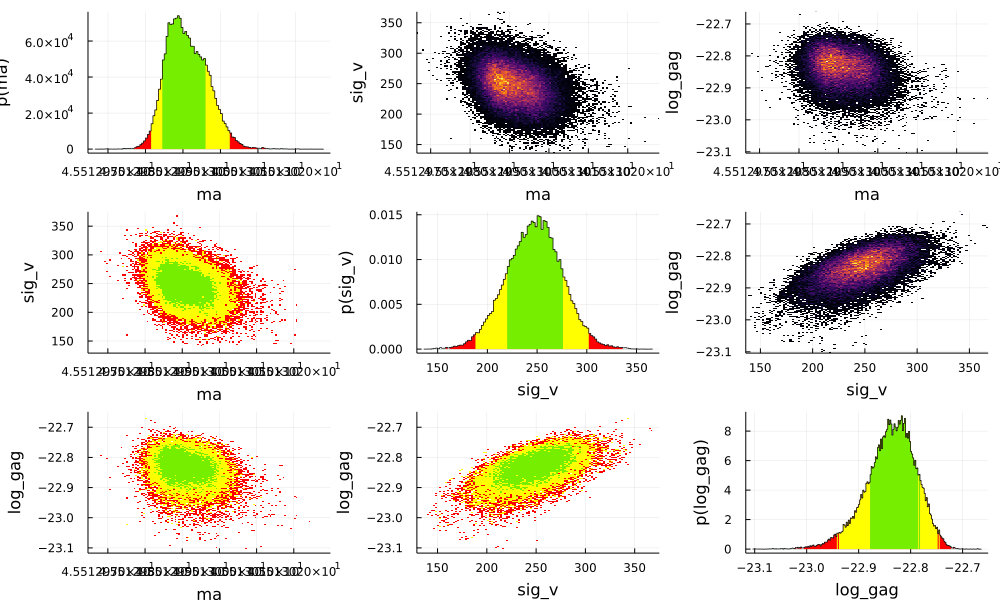

In [12]:
using Plots
using Statistics

println("Means: $(mean(samples)[1])")
println("Stds: $(std(samples)[1])")

plot(samples)

Did we find the axion?

(ma = 45.51298824573586, sig_v = 251.11154861268997, log_gag = -22.819885280182973)


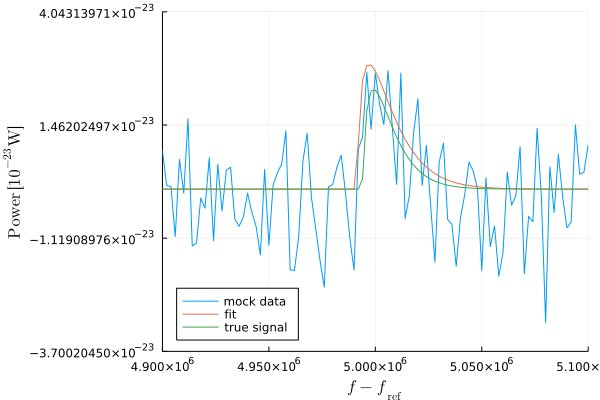

In [13]:
plot_fit(samples, data, ex; truths=signal, xrange=(4.9e6,5.1e6))